In [1]:
import keras
from keras.datasets import fashion_mnist
import numpy as np
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, InputLayer, Input
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# data set of dim 28x28 greyscale images
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# original dimensions of train & test datasets
x_train.shape, x_test.shape, type(x_train)

4423680/4422102 [==============================] - 3s 1us/step


((60000, 28, 28), (10000, 28, 28), numpy.ndarray)

In [3]:
# normalize to range [0,1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape to include channel in dimension
# TODO: change channel to 3 when using RGB images
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # by default uses `channels_last` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Dimensions after including channel info
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [4]:
def add_noise(data, noise_factor = 0.5):
    # add noise
    res = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape) 

    # clip to range
    res = np.clip(res, 0., 1.)
    return res

# def add_noise(data, noise_factor = 0.5):
#      mean = 0
#      sigma = 50
#     # add noise
#     row,col,ch = data.shape
#     gauss = np.random.normal(mean, sigma,(row,col,ch))
#     import pdb
#     pdb.set_trace()
#     gauss = gauss.reshape(row,col,ch)
#     # clip to range
#     res = data + gauss
#     return res

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

In [5]:
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

In [6]:
# KL Divergence regularizer for hidden unit activations
import keras # if using keras
import tensorflow as tf
# from tensorflow import keras # if using tf.keras
kullback_leibler_divergence = keras.losses.kullback_leibler_divergence
K = keras.backend

def kl_divergence_regularizer(activations):
    rho_hat = K.mean(activations, axis=0)
    nprho = np.full((rho_hat.get_shape().as_list()[0],) ,0.05)
    rho = tf.convert_to_tensor(nprho, dtype=tf.float32)
    return 0.01 * (kullback_leibler_divergence(rho, rho_hat)
                 + kullback_leibler_divergence(1 - rho, 1 - rho_hat))

In [7]:
x_train.shape, x_train_noisy.shape, x_test.shape, x_test_noisy.shape

((60000, 28, 28, 1),
 (60000, 28, 28, 1),
 (10000, 28, 28, 1),
 (10000, 28, 28, 1))

In [8]:
# reshape(flatten) so that we can pass to neural network
x_train = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
x_train_noisy = x_train_noisy.reshape(len(x_train_noisy), np.prod(x_train_noisy.shape[1:]))

x_test = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))
x_test_noisy = x_test_noisy.reshape(len(x_test_noisy), np.prod(x_test_noisy.shape[1:]))

# shape after flattening
x_train.shape, x_train_noisy.shape, x_test.shape, x_test_noisy.shape

((60000, 784), (60000, 784), (10000, 784), (10000, 784))

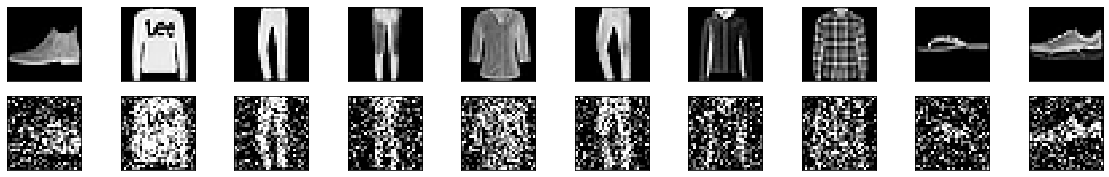

In [9]:
# print first 10 test images
n = 10
plt.figure(figsize=(20, 3))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+10)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

plt.show()

In [10]:
lambdaa = 0.000001
input_layer = Input(shape=(784,))
hidden_layer = Dense(units=3*784, activation='sigmoid', 
                    activity_regularizer=kl_divergence_regularizer,
                    kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(input_layer)
output_layer = Dense(units=784, activation='sigmoid',
                    kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(hidden_layer)
da1 = Model(input_layer, output_layer)
da1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2352)              1846320   
_________________________________________________________________
dense_2 (Dense)              (None, 784)               1844752   
Total params: 3,691,072
Trainable params: 3,691,072
Non-trainable params: 0
_________________________________________________________________


In [11]:
da1.compile("adam", loss='mse')
da1.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=120,
                shuffle=True)

Epoch 1/50
60000/60000 [==============================] - 8s 128us/step - loss: 0.1736
Epoch 2/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.0536
Epoch 3/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.0429
Epoch 4/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.0397
Epoch 5/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.0381
Epoch 6/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.0371
Epoch 7/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.0367
Epoch 8/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.0366
Epoch 9/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.0365
Epoch 10/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.0363
Epoch 11/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.0365
Epoch 12/50
60000/60000 [==========================

In [12]:
predicted = da1.predict(x_test_noisy)

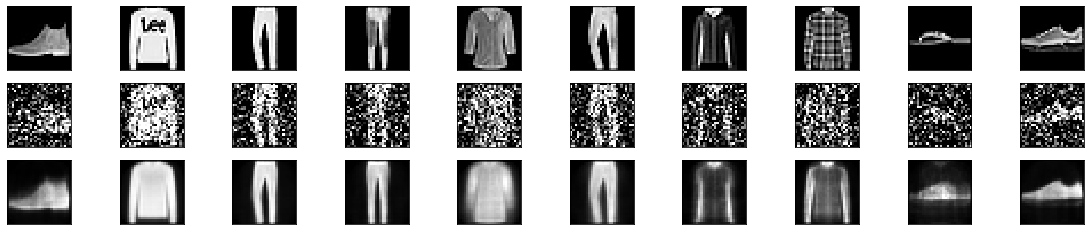

In [13]:
plt.figure(figsize=(40, 4))
for i in range(10):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noisy images
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(x_test_noisy[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(predicted[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()

In [14]:
import pandas as pd

hiddenLayerWeights = pd.DataFrame(da1.layers[1].get_weights()[0]).values
hiddenLayerBias = pd.DataFrame(da1.layers[1].get_weights()[1]).values
hiddenLayerWeights.shape, type(hiddenLayerWeights), hiddenLayerBias.shape, type(hiddenLayerBias)

Wx = np.dot(x_train_noisy, hiddenLayerWeights)
b =  hiddenLayerBias.T
hX = sigmoid(Wx+b)

Wy = np.dot(x_train, hiddenLayerWeights)
hY = sigmoid(Wy + b)

In [15]:
hX.shape, hY.shape

((60000, 2352), (60000, 2352))

In [16]:
input_layer2 = Input(shape=(3*784,))
hidden_layer2 = Dense(units=3*3*784, activation='sigmoid',
                    activity_regularizer=kl_divergence_regularizer,
                    kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(input_layer2)
output_layer2 = Dense(units=3*784, activation='sigmoid',
                    kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(hidden_layer2)
da2 = Model(input_layer2, output_layer2)
da2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2352)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 7056)              16602768  
_________________________________________________________________
dense_4 (Dense)              (None, 2352)              16598064  
Total params: 33,200,832
Trainable params: 33,200,832
Non-trainable params: 0
_________________________________________________________________


In [17]:
da2.compile(optimizer='adam', loss='mse')
da2.fit(hX, hY,
                epochs=50,
                batch_size=120,
                shuffle=True)

Epoch 1/50
60000/60000 [==============================] - 14s 230us/step - loss: 0.7008
Epoch 2/50
60000/60000 [==============================] - 10s 163us/step - loss: 0.0557
Epoch 3/50
60000/60000 [==============================] - 10s 162us/step - loss: 0.0490
Epoch 4/50
60000/60000 [==============================] - 10s 164us/step - loss: 0.0455
Epoch 5/50
60000/60000 [==============================] - 10s 163us/step - loss: 0.0447
Epoch 6/50
60000/60000 [==============================] - 10s 162us/step - loss: 0.0412
Epoch 7/50
60000/60000 [==============================] - 10s 162us/step - loss: 0.0397
Epoch 8/50
60000/60000 [==============================] - 10s 162us/step - loss: 0.0398
Epoch 9/50
60000/60000 [==============================] - 10s 162us/step - loss: 0.0395
Epoch 10/50
60000/60000 [==============================] - 10s 162us/step - loss: 0.0369
Epoch 11/50
60000/60000 [==============================] - 10s 162us/step - loss: 0.0377
Epoch 12/50
60000/60000 [=====

In [18]:
# Extract weights
W1, B1 = da1.layers[1].get_weights()
W1_dash, B1_dash = da1.layers[2].get_weights()

W2, B2 = da2.layers[1].get_weights()
W2_dash, B2_dash = da2.layers[2].get_weights()


In [19]:
W1.shape, W2.shape, W2_dash.shape, W1_dash.shape
# B1.shape, B2.shape, B2_dash.shape, B1_dash.shape
# len(B1), len(B2), len(B2_dash), len(B1_dash)

((784, 2352), (2352, 7056), (7056, 2352), (2352, 784))

In [20]:
input_layer = Input(shape=(W1.shape[0],))
h1 = Dense(units=W1.shape[1], activation='sigmoid', 
#                     kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(input_layer)
h2 = Dense(units=W2.shape[1], activation='sigmoid', 
#                     kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(h1)
h3 = Dense(units=W2_dash.shape[1], activation='sigmoid', 
#                     kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(h2)
output_layer = Dense(units=W1_dash.shape[1], activation='sigmoid',
#                     kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(h3)

dnn = Model(input_layer, output_layer)

# Initialize with pretrained weights
B1 = np.random.uniform(0,1,B1.shape)
B2 = np.random.uniform(0,1,B2.shape)
B1_dash = np.random.uniform(0,1,B1_dash.shape)
B2_dash = np.random.uniform(0,1,B2_dash.shape)

dnn.layers[1].set_weights([W1, B1])
dnn.layers[2].set_weights([W2, B2])
dnn.layers[3].set_weights([W2_dash, B2_dash])
dnn.layers[4].set_weights([W1_dash, B1_dash])

dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2352)              1846320   
_________________________________________________________________
dense_6 (Dense)              (None, 7056)              16602768  
_________________________________________________________________
dense_7 (Dense)              (None, 2352)              16598064  
_________________________________________________________________
dense_8 (Dense)              (None, 784)               1844752   
Total params: 36,891,904
Trainable params: 36,891,904
Non-trainable params: 0
_________________________________________________________________


In [21]:
# x_sample = x_train[0].reshape(28, 28)
# plt.imshow(x_sample, interpolation='nearest')
# plt.show()

In [22]:
dnn.compile('adam', loss='mse')
dnn.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=120,
                shuffle=True)

Epoch 1/100
60000/60000 [==============================] - 11s 181us/step - loss: 0.0259
Epoch 2/100
60000/60000 [==============================] - 9s 152us/step - loss: 0.0195
Epoch 3/100
60000/60000 [==============================] - 9s 152us/step - loss: 0.0178
Epoch 4/100
60000/60000 [==============================] - 9s 152us/step - loss: 0.0168
Epoch 5/100
60000/60000 [==============================] - 9s 152us/step - loss: 0.0161
Epoch 6/100
60000/60000 [==============================] - 9s 153us/step - loss: 0.0155
Epoch 7/100
60000/60000 [==============================] - 9s 152us/step - loss: 0.0151
Epoch 8/100
60000/60000 [==============================] - 9s 152us/step - loss: 0.0147
Epoch 9/100
60000/60000 [==============================] - 9s 152us/step - loss: 0.0143
Epoch 10/100
60000/60000 [==============================] - 9s 152us/step - loss: 0.0140
Epoch 11/100
60000/60000 [==============================] - 9s 152us/step - loss: 0.0137
Epoch 12/100
60000/60000 [===

In [23]:
predicted2 = dnn.predict(x_test_noisy)

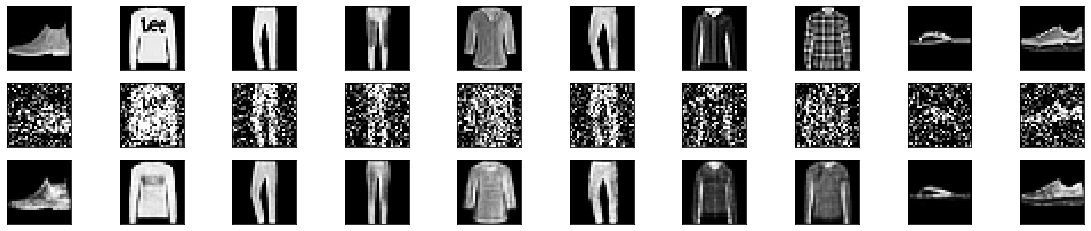

In [24]:
plt.figure(figsize=(40, 4))
for i in range(10):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noisy images
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(x_test_noisy[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(3, 20, 2 * 20 + i + 1)
    plt.imshow(predicted2[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()